# Projeto Final EEL7514 - Neural Style Transfer
Alunos: 
         __Bruno Griep Fernandes__ e 
         __Roberto Phillipi Martins__

__Neural Style Transfer__ é o processo em que retira-se o estilo de uma imagem de referência e aplica-se esse estilo em uma imagem alvo. Um exemplo prático disso seria em usar uma foto de uma casa como alvo e uma obra de arte como referência. Dessa forma ao transferir o estilo da obra de arte a imagem gerada irá parecer que a casa foi criada pelo artista da obra de arte. Vale lembrar que é gerada uma nova imagem, ou seja, são duas duas entradas e uma saída, onde as entradas não são modificadas.

__Estilo__ para definirmos o estilo algumas features são importantes sedo elas: 
        - A coloração;
        - A textura;  
        - O padrão.
__Content__ é definido como a estrutura total e as compoentes de alto nível da imagem. O objetivo principal é manter o conteúdo original da imagem de alvo, isso enquanto o estilo é transferindo.

__Algorítmo__ funciona basicamente na minimização de uma função custo, que envolve as imagens de conteúdo (C), estilo (S) e gerada (G).



\begin{align*}
    J(C,S,G) &= \alpha Jc(C,G) + \beta Js(S,G)\\
    Jc(C,G)^{[L]} &=  \frac{1}{2}||a^{[L][G]}-a^{[L][G]}||^2\\
    Js(S,G)^{[L]} &= \frac{1}{2} ||G^{[L][S]}-G^{[L][G]}||^2\\
    G^{[L][I]} &=\left(\sum_{k=0}^{k=ch}\sum_{k'=0}^{k'=ch} \right)
\sum_{i=0}^{i=w}\sum_{j=0}^{j=h}||a^{[L][i][j][k]}-a^{[L][i][j][k']}||^2
\end{align*}

Onde Jc(C,G) representa a distância euclidiana entre as ativações da imagem C e imagem G numa camada L. Como queremos minimizar o custo, isso significa que queremos que as representações de C e G na camada L sejam similares.

No caso de Js(S,G), nós definimos o "estilo" de uma imagem como a correlação entre os canais de uma camada de ativação da rede convolucional. Este valor é definido como G (Gram Matrix),e é a matriz de correlação entre os diversos canais de uma camada da rede convolucional. 

O objetivo é que o estilo da imagem G seja similar ao estilo da imagem S, e portanto Js(S,G) é definido como a distância euclidiana entre os estilos das duas imagens.

Definido o custo, o objetivo do algorítimo é minimizar a função J(C,S,G), e pode ser resolvido com algorítimos como Gradient Descent

__Loss__ no nosso contexto de processamento de imagens podemos definir a perda a partir da seguinte forma:
$$loss = distance(style(Image_{reference}) - style(Image_{generated})) +
       distance(content(Image_{original}) - content(Image_{generated}))$$
       
Onde, 

- $distance$ é a distância euclidiana.
- $style$ é a função que calcula a presença do estilo na imagem de referência na gerada.
- $content$ é a função que calcula a representação do conteúdo da imagem original na gerada.
(essa parte aqui melhorar, ficou estranho)


# Referências:
 
- Image Super-Resolution Using CNN - https://arxiv.org/abs/1501.00092 
- A Neural Algorithm of Artistic Style - https://arxiv.org/abs/1508.06576
- Improving the Neural Algorithm of Artistic Style - https://arxiv.org/abs/1605.04603
- Preserving Color in Neural Artistic Style - https://arxiv.org/abs/1606.05897
- very Deep Convolutional Networks for Large-Scale Image Recognition - https://arxiv.org/abs/1409.1556

## Visualizando as imagens a ser utilizidas

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input,decode_predictions

In [5]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [29]:
datapath = 'data/'
content = Image.open(datapath + 'content/golden_gate.jpg')
style = Image.open(datapath + 'style/wave_kanagawa.jpg')

print('Content Shape:',np.shape(content),'\nStyle Shape:', np.shape(style))

Content Shape: (734, 979, 3) 
Style Shape: (707, 1131, 3)


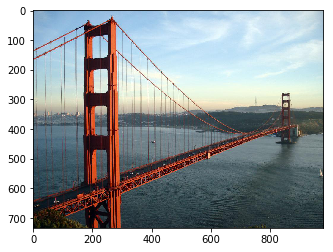

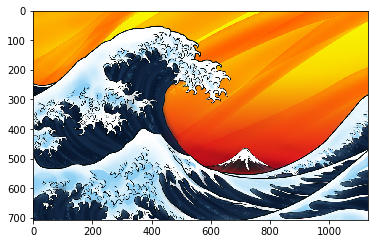

In [28]:
plt.imshow(content)
plt.figure()
plt.imshow(style)

## Pré-processamento das Imagens

Aqui alguns passos serão feitos para que o processamento usando a rede VGG serja mais curto em quesitos de tempo.
    - Modifica-se as dimensões das duas imagens para ambas terem o mesmo tamanho;
    - Substrai o valor médio de cores (RGB);
    - Inverte-se a ordem multidimencional do array de cores, ou seja, ao invés de usar o padrão RGB usa-se o BGR.

In [34]:
height = 512
width = 512

content = content.resize((height,width))
style = style.resize((height,width))

content_array = np.asarray(content,dtype='float32')
content_array = np.expand_dims(content_array,axis=0)

style_array = np.asarray(style,dtype='float32')
style_array = np.expand_dims(style_array,axis=0)

print('Content Shape:',content_array.shape,'\nStyle Shape:', style_array.shape)

Content Shape: (1, 512, 512, 3) 
Style Shape: (1, 512, 512, 3)


In [35]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]

print('Content Shape:',content_array.shape,'\nStyle Shape:  ', style_array.shape)

Content Shape: (1, 512, 512, 3) 
Style Shape:   (1, 512, 512, 3)


Feitas as modificações parte-se para a definição das variáveis do backend do keras.

In [36]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Concatena-se as imagens para um único tensor para ser utilizado na rede VGG19

In [38]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)